In [ ]:
!pip install transformers
!pip install matplotlib scikit-learn

## Uploading the Dataset

In [2]:
from google.colab import files
import pandas as pd

# Upload the dataset and read the dataset
uploaded = files.upload()


df = pd.read_csv(next(iter(uploaded)))


df.head()


Saving LLM_dataset.csv to LLM_dataset.csv


,x_i,x_j,Label
0,he held her back and,"whispered urgently for her to stay calm, sensi...",GPT4o
1,none of her previous boyfriends had,had lasted this long.,GPT4o
2,"our clothes quickly disappeared , until we stood",naked in the moonlight.,GPT4o
3,but dagmar was not some mindless,follower; she had a plan.,GPT4o
4,"she paused , obviously",uncertain of what to say next.,GPT4o


## Preprocessing dataset

In [3]:
# Check for missing values and combine x_i and x_j
df.isnull().sum()


df['combined_text'] = df['x_i'] + ' ' + df['x_j']


df[['combined_text', 'Label']].head()


,combined_text,Label
0,he held her back and whispered urgently for he...,GPT4o
1,none of her previous boyfriends had had lasted...,GPT4o
2,"our clothes quickly disappeared , until we sto...",GPT4o
3,but dagmar was not some mindless follower; she...,GPT4o
4,"she paused , obviously uncertain of what to sa...",GPT4o


In [4]:
from sklearn.model_selection import train_test_split

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df['combined_text'], df['Label'], test_size=0.2, random_state=42)


## Tokenize the dataset and convert it into a PyTorch datset

In [ ]:
from transformers import DistilBertTokenizer
# Load the tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

X_train = [str(text) for text in X_train]
X_test = [str(text) for text in X_test]
train_encodings = tokenizer(list(X_train), truncation=True, padding=True, max_length=512, return_tensors='pt')
test_encodings = tokenizer(list(X_test), truncation=True, padding=True, max_length=512, return_tensors='pt')


In [6]:
import torch
from torch.utils.data import Dataset, DataLoader

class TextDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Convert labels to tensors
y_train = y_train.astype('category').cat.codes.tolist()  # Convert labels to integers
y_test = y_test.astype('category').cat.codes.tolist()

# Create PyTorch datasets
train_dataset = TextDataset(train_encodings, y_train)
test_dataset = TextDataset(test_encodings, y_test)

# Create DataLoader objects
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


## Load model

In [ ]:
from transformers import DistilBertForSequenceClassification, AdamW

# Load the pre-trained DistilBERT model for classification
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=5)

# Set up the optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)


## Training

In [8]:
from tqdm import tqdm

# Training loop
model.train()
for epoch in range(3):  # Train for 3 epochs
    loop = tqdm(train_loader, leave=True)
    for batch in loop:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loop.set_description(f'Epoch {epoch}')
        loop.set_postfix(loss=loss.item())


  0%|          | 0/1250 [00:00<?, ?it/s]<ipython-input-6-fa6cf741caec>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 2: 100%|██████████| 1250/1250 [02:46<00:00,  7.51it/s, loss=0.555]


## Testing

In [9]:
from sklearn.metrics import accuracy_score, classification_report
model.eval()
class_names = ['GPT2', 'GPT4o', 'GPT_NEO', 'Gemini', 'Reformer']
preds = []
true_labels = []

with torch.no_grad():
    for batch in test_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1).cpu().numpy()
        labels = batch['labels'].cpu().numpy()
        preds.extend(predictions)
        true_labels.extend(labels)
accuracy = accuracy_score(true_labels, preds)
print(f'Accuracy: {accuracy}')
print(classification_report(true_labels, preds, target_names=class_names))


<ipython-input-6-fa6cf741caec>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Accuracy: 0.663
              precision    recall  f1-score   support

        GPT2       0.54      0.61      0.57      1000
       GPT4o       0.74      0.58      0.65      1021
     GPT_NEO       0.54      0.51      0.53       989
      Gemini       0.59      0.70      0.64      1005
    Reformer       0.95      0.91      0.93       985

    accuracy                           0.66      5000
   macro avg       0.67      0.66      0.67      5000
weighted avg       0.67      0.66      0.66      5000



## Some sample outputs

In [10]:
import random


class_names = ['GPT2', 'GPT4o', 'GPT_NEO', 'Gemini', 'Reformer']

random_indices = random.sample(range(len(X_test)), 10)

# Show the true label, predicted label, and whether they match
for idx in random_indices:
    text = X_test[idx]  
    true_label = class_names[true_labels[idx]]  # Convert true label from int to class name
    predicted_label = class_names[preds[idx]]  # Convert predicted label from int to class name
    print(f"Text: {text}")
    print(f"True Label: {true_label}")
    print(f"Predicted Label: {predicted_label}")
    print(f"Match: {true_label == predicted_label}")
    print('-' * 80)


Text: brett lost control of the car , skidded into a ditch and was thrown into the ditch.
True Label: GPT_NEO
Predicted Label: GPT2
Match: False
--------------------------------------------------------------------------------
Text: i would never be be the same again after witnessing such violence.
True Label: Gemini
Predicted Label: Gemini
Match: True
--------------------------------------------------------------------------------
Text:  why are you offering ???ell????ou are not so????hy,
True Label: Reformer
Predicted Label: Reformer
Match: True
--------------------------------------------------------------------------------
Text: and in those roles , since no one anyone could have predicted the outcome.
True Label: Gemini
Predicted Label: GPT4o
Match: False
--------------------------------------------------------------------------------
Text: make it a whole one .The first thing I did was to make a list of all the things I wanted to do with the game. I wanted to make it a game tha

## ROC curve metric

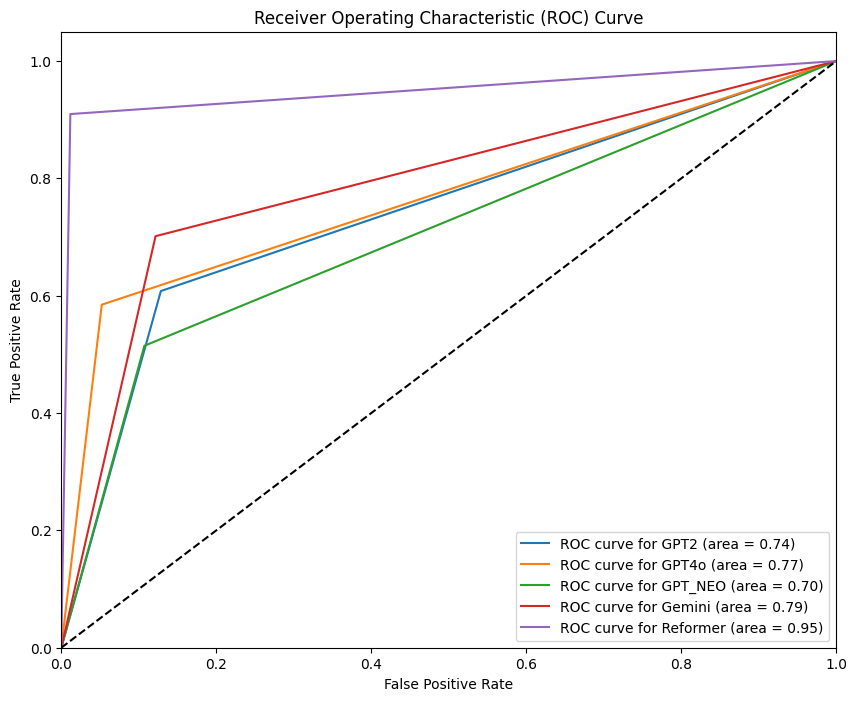

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import RocCurveDisplay

y_true_binarized = label_binarize(true_labels, classes=[0, 1, 2, 3, 4])
y_pred_binarized = label_binarize(preds, classes=[0, 1, 2, 3, 4])

# Compute ROC curve and ROC area for each class
n_classes = len(class_names)
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_pred_binarized[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve for {class_names[i]} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()
